# Preamble

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/code/func/')
from proj_environment import set_proj_env
from func import get_cmap

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 'fsFinalExclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'lausanne' # 'schaefer' 'lausanne'
parc_scale = 250 # 200 400 | 60 125 250
_ = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str, parc_str = parc_str, parc_scale = parc_scale)

### Setup output directory

In [4]:
print(os.environ['TRTEDIR'])
if not os.path.exists(os.environ['TRTEDIR']): os.makedirs(os.environ['TRTEDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/fsFinalExclude/squeakycleanExclude


# Load in metadata

In [5]:
# LTN and Health Status
health = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/health/n1601_health_20170421.csv'))
# Protocol
prot = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/n1601_pnc_protocol_validation_params_status_20161220.csv'))
# T1 QA
t1_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_t1QaData_20170306.csv'))
# DTI QA
dti_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/dti/n1601_dti_qa_20170301.csv'))
# Rest QA
rest_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/rest/n1601_RestQAData_20170714.csv'))
# Demographics
demog = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/demographics/n1601_demographics_go1_20161212.csv'))
# Brain volume
brain_vol = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_ctVol20170412.csv'))

# GOASSESS Bifactor scores
goassess = pd.read_csv('/Users/lindenmp/Dropbox/Work/ResData/PNC/GO1_clinical_factor_scores_psychosis_split_BIFACTOR.csv')
# Psych summary
psych = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/clinical/n1601_goassess_psych_summary_vars_20131014.csv'))
# Psychosis summary
psychosis = pd.read_csv('/Users/lindenmp/Dropbox/Work/ResData/PNC/n1601_diagnosis_dxpmr_20170509.csv')


# merge
df = health
df = pd.merge(df, prot, on=['scanid', 'bblid']) # prot
df = pd.merge(df, t1_qa, on=['scanid', 'bblid']) # t1_qa
df = pd.merge(df, dti_qa, on=['scanid', 'bblid']) # dti_qa
df = pd.merge(df, rest_qa, on=['scanid', 'bblid']) # rest_qa
df = pd.merge(df, demog, on=['scanid', 'bblid']) # demog
df = pd.merge(df, goassess, on=['bblid']) # goassess
df = pd.merge(df, psych, on=['scanid', 'bblid']) # goassess
df = pd.merge(df, psychosis, on=['scanid', 'bblid']) # goassess
df = pd.merge(df, brain_vol, on=['scanid', 'bblid']) # brain_vol

print(df.shape[0])
df.set_index(['bblid', 'scanid'], inplace = True)

1599


In [6]:
# Convert age to years
df['ageAtScan1_Years'] = np.round(df.ageAtScan1/12, decimals=1)

In [7]:
df.head()

,,timepoint_x,smrytrt_psychinpt,psychoactiveMedPsychv2,psychoactiveMedMedicalv2,incidentalFindingExclude,medicalratingExcludev1,healthExcludev2,ltnExcludev2,squeakycleanExclude,psychoactiveMedMedical,...,goassessDxpmr6,goassessDxpmr7,mprage_antsCT_vol_CSF,mprage_antsCT_vol_GrayMatter,mprage_antsCT_vol_WhiteMatter,mprage_antsCT_vol_DeepGrayMatter,mprage_antsCT_vol_BrainStem,mprage_antsCT_vol_Cerebellum,mprage_antsCT_vol_TBV,ageAtScan1_Years
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
80961,2632,1,0,1,0,0,0,0,1,1,0,...,PS,PS,251420.729266,616556.953530,389490.709524,52141.098450,17099.116230,140667.147488,1.467376e+06,21.6
80199,2637,1,0,0,0,0,0,0,0,0,0,...,TD,PS,273991.914252,642746.594518,447142.548594,56126.058254,19814.056864,150808.843822,1.590630e+06,20.3
80179,2643,1,1,1,0,0,0,0,1,1,0,...,TD,TD,234354.132558,524247.214162,360616.889612,38010.047782,16670.210102,136221.640940,1.310120e+06,21.2
81005,2644,1,0,0,0,0,1,1,1,1,0,...,TD,TD,284533.512816,607386.448326,361763.861942,46560.045350,16218.452418,138964.706566,1.455427e+06,20.1
80812,2646,1,0,0,0,0,0,0,0,1,0,...,PS,PS,254232.349560,605785.081594,471565.588522,46874.693698,20525.091818,141902.010418,1.540885e+06,20.6


# Filter subjects

In [8]:
# 1) Primary sample filter
df = df[df['healthExcludev2'] == 0]
print('N after initial exclusion:', df.shape[0])

# 2) T1 exclusion
df = df[df[exclude_str] == 0]
print('N after T1 exclusion:', df.shape[0])

N after initial exclusion: 1445
N after T1 exclusion: 1382


In [9]:
df['averageManualRating'].unique()

array([2.   , 1.667, 1.333, 1.   ])

In [10]:
np.sum(df['averageManualRating'] == 2)

1143

# Define train/test split

In [11]:
if train_test_str == 'squeakycleanExclude':
    # 1) Use squeakycleanExclude
    # For PNC, the train/test split is based upon the 'squeakycleanExclude' criteria. From the wiki:
    # "This category excludes all subjects with any screening diagnosis as found by the GOASSESS clinical screening instrument.
    # Note that this is NOT a commonly used criteria except for sensitivity analysis, and in general we would prefer to not
    # have studies use this without a strong rationale; would discuss with your BBL liaison."
    # train = squeakycleanExclude == 0 --> retain those WITHOUT any lifetime psychopathology 
    # test = squeakycleanExclude == 1 --> retain those WITH lifetime psychopathology
    print('Train: ', np.sum(df[train_test_str] == 0), 'Test:', np.sum(df[train_test_str] == 1))

Train:  404 Test: 978


# Characterise train/test split

## Train/Test split

In [12]:
# find unique ages
age_unique = np.unique(df.ageAtScan1_Years)
print('There are', age_unique.shape[0], 'unique age points')

# Check if train and test represent the full unique age space
train_diff = np.setdiff1d(df[df[train_test_str] == 0].ageAtScan1_Years,age_unique)
test_diff = np.setdiff1d(df[df[train_test_str] == 1].ageAtScan1_Years,age_unique)

if train_diff.size == 0:
    print('All unique age points are represented in the training set')
elif train_diff.size != 0:
    print('All unique age points ARE NOT represented in the training set')
    
if test_diff.size == 0:
    print('All unique age points are represented in the testing set')
elif test_diff.size != 0:
    print('All unique age points ARE NOT represented in the testing set')

There are 149 unique age points
All unique age points are represented in the training set
All unique age points are represented in the testing set


## Export

In [13]:
header = [train_test_str, 'ageAtScan1', 'ageAtScan1_Years','sex','race2','handednessv2',
          'dti64MeanAbsRMS','dti64MeanRelRMS','dti64MaxAbsRMS','dti64MaxRelRMS','mprage_antsCT_vol_TBV', 'averageManualRating',
          'Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear',
          'goassessSmryMood', 'goassessSmryMan', 'goassessSmryDep', 'goassessSmryEat', 'goassessSmryBul',
          'goassessSmryAno', 'goassessSmryAnx', 'goassessSmryGad', 'goassessSmrySep', 'goassessSmryPhb', 'goassessSmrySoc',
          'goassessSmryPan', 'goassessSmryAgr', 'goassessSmryOcd', 'goassessSmryPtd', 'goassessSmryPsy', 'goassessSmryDel',
          'goassessSmryHal', 'goassessSmryHalAv', 'goassessSmryHalAs', 'goassessSmryHalVh', 'goassessSmryHalOh', 'goassessSmryHalTh',
          'goassessSmryBeh', 'goassessSmryAdd', 'goassessSmryOdd', 'goassessSmryCon', 'goassessSmryPrimePos1', 'goassessSmryPrimeTot',
          'goassessSmryPrimePos2', 'goassessSmryPsychOverallRtg', 'goassessDxpmr7']
df.to_csv(os.path.join(os.environ['TRTEDIR'], 'df_pheno.csv'), columns = header)

# Plots

In [14]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

labels = ['Train', 'Test']
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']
print(phenos)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear']


## Age

In [15]:
df['sex'].unique()

array([1, 2])

In [16]:
np.sum(df.loc[df[train_test_str] == 1,'sex'] == 2)

530

Figure 2A

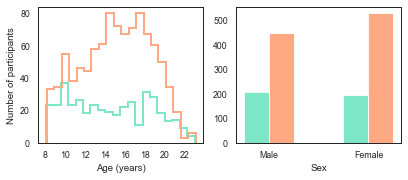

In [17]:
f, axes = plt.subplots(1,2)
f.set_figwidth(6.5)
f.set_figheight(2.5)
colormap = sns.color_palette("pastel", 2)

sns.distplot(df.loc[df[train_test_str] == 0,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[0],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[0]), ax = axes[0]);
sns.distplot(df.loc[df[train_test_str] == 1,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[1],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[1]), ax = axes[0]);
axes[0].set_xlabel('Age (years)');
axes[0].set_ylabel('Number of participants');
axes[0].set_xticks(np.arange(np.min(np.round(age_unique,0)), np.max(np.round(age_unique,0)), 2))

# set width of bar
barWidth = 0.25

# Sex
y_train = [np.sum(df.loc[df[train_test_str] == 0,'sex'] == 1), np.sum(df.loc[df[train_test_str] == 0,'sex'] == 2)]
y_test = [np.sum(df.loc[df[train_test_str] == 1,'sex'] == 1), np.sum(df.loc[df[train_test_str] == 1,'sex'] == 2)]
r1 = np.arange(len(y_train))+barWidth/2
r2 = [x + barWidth for x in r1]
axes[1].bar(r1, y_train, width = barWidth, color = cmap[0], label = labels[0])
axes[1].bar(r2, y_test, width = barWidth, color = cmap[1], label = labels[1])
axes[1].set_xlabel('Sex')
# axes[1].set_ylabel('Number of participants')
axes[1].set_xticks([r + barWidth for r in range(len(y_train))])
axes[1].set_xticklabels(['Male', 'Female'])

f.savefig('age_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Phenotype distributions over train/test

Figure 2B

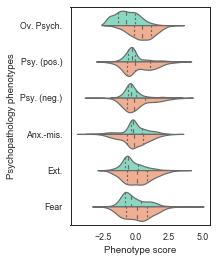

In [18]:
df_rc = pd.melt(df, id_vars = train_test_str, value_vars = phenos)

f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(4)
ax = sns.violinplot(y='variable', x='value', hue=train_test_str, data=df_rc, palette = cmap, split=True, scale='width', inner = 'quartile', orient = 'h')
ax.get_legend().remove()
ax.set_yticklabels(phenos_label_short)
ax.set_ylabel('Psychopathology phenotypes')
ax.set_xlabel('Phenotype score')
f.savefig('phenos_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)